In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("2.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

print("Summary of dataGene:\n",dataGene.describe())

Summary of dataGene:
        log_2FoldChange            ET  CoExpression           PCC  \
count     41110.000000  41110.000000  41110.000000  41110.000000   
mean         -0.037332      1.407395      0.991997     -0.361737   
std           0.391444      0.784327      0.089101      0.463979   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.747963   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.051646   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling  \
count  41110.000000        41110.000000        41110.000000   
mean       0.914668           -0.522040           -0.646982   
std        0.279379            0.498568            0.393549   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.901371           

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['Root10DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot10DaysSeedling', 'Shoot35DaysSeedling', 'Root35DaysSeedling', 
                 'Leaf21DaysSeedling', 'Root14DaysSeedling', 'Shoot3DaysSeedling', 'Root24DaysSeedling', 'Root52DaysSeedling', 
                 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot14DaysSeedling', 'Shoot21DaysSeedling', 'Shoot17DaysSeedling',
                  'ET', 'PCC', 'log_2FoldChange', 'PPI', 'CoExpression']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X_fs.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
Summary of X:
        Root10DaysSeedling  Leaf45DaysOldPlant  Shoot10DaysSeedling  \
count        41110.000000        41110.000000         41110.000000   
mean            -0.522040           -0.585144            -0.545055   
std              0.498568            0.399046             0.477438   
min             -1.000000           -1.000000            -1.000000   
25%             -0.901371           -0.901444            -0.906055   
50%             -0.663664           -0.643376            -0.698864   
75%             -0.378497           -0.451900            -0.250588   
max              1.000000            1.000000             1.000000   

       Shoot35DaysSeedling  Root35DaysSeedling  Leaf21DaysSeedling  \
count         41110.000000        41110.000000        41110.000000   
mean             -0.558906           -0.596196           -0.828778   
std               0.506423            0.461679            0.327542   
min              -1.000000 

Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

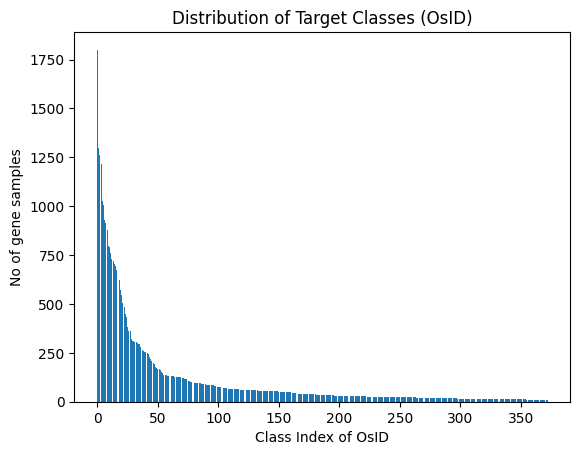

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=20, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

Number of input features: 1
Fold: 1
Epoch 1/20
1846/1846 [==============================] - 16s 7ms/step - loss: 4.4897 - accuracy: 0.1007 - val_loss: 4.0962 - val_accuracy: 0.1204
Epoch 2/20
1846/1846 [==============================] - 12s 6ms/step - loss: 3.7918 - accuracy: 0.1682 - val_loss: 3.7338 - val_accuracy: 0.1925
Epoch 3/20
1846/1846 [==============================] - 12s 7ms/step - loss: 3.4393 - accuracy: 0.2285 - val_loss: 3.4744 - val_accuracy: 0.2609
Epoch 4/20
1846/1846 [==============================] - 12s 7ms/step - loss: 3.1776 - accuracy: 0.2671 - val_loss: 3.2773 - val_accuracy: 0.2499
Epoch 5/20
1846/1846 [==============================] - 11s 6ms/step - loss: 2.9827 - accuracy: 0.2905 - val_loss: 3.1525 - val_accuracy: 0.3105
Epoch 6/20
1846/1846 [==============================] - 12s 6ms/step - loss: 2.8385 - accuracy: 0.3106 - val_loss: 3.0506 - val_accuracy: 0.2968
Epoch 7/20
1846/1846 [==============================] - 12s 7ms/step - loss: 2.7327 - accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 4.0995 - accuracy: 0.1821 - val_loss: 3.4167 - val_accuracy: 0.2878
Epoch 2/20
1846/1846 [==============================] - 11s 6ms/step - loss: 2.8680 - accuracy: 0.3768 - val_loss: 2.6935 - val_accuracy: 0.4607
Epoch 3/20
1846/1846 [==============================] - 11s 6ms/step - loss: 2.2144 - accuracy: 0.5189 - val_loss: 2.2021 - val_accuracy: 0.5976
Epoch 4/20
1846/1846 [==============================] - 11s 6ms/step - loss: 1.7707 - accuracy: 0.5944 - val_loss: 1.8704 - val_accuracy: 0.6493
Epoch 5/20
1846/1846 [==============================] - 11s 6ms/step - loss: 1.4994 - accuracy: 0.6370 - val_loss: 1.7087 - val_accuracy: 0.6251
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 1.3402 - accuracy: 0.6592 - val_loss: 1.5761 - val_accuracy: 0.6673
Epoch 7/20
1846/1846 [==============================] - 11s 6ms/step - loss: 1.2326 - accuracy: 0.6791 - val_loss: 1.4537 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 6ms/step - loss: 3.8138 - accuracy: 0.2651 - val_loss: 2.8913 - val_accuracy: 0.4645
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.2555 - accuracy: 0.5383 - val_loss: 2.0795 - val_accuracy: 0.5776
Epoch 3/20
1846/1846 [==============================] - 10s 5ms/step - loss: 1.5402 - accuracy: 0.6549 - val_loss: 1.5763 - val_accuracy: 0.6909
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 1.1331 - accuracy: 0.7303 - val_loss: 1.2375 - val_accuracy: 0.7611
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.9124 - accuracy: 0.7667 - val_loss: 1.0907 - val_accuracy: 0.7835
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.7937 - accuracy: 0.7912 - val_loss: 0.9965 - val_accuracy: 0.7910
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.7229 - accuracy: 0.8039 - val_loss: 0.9459 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 6ms/step - loss: 3.8647 - accuracy: 0.2583 - val_loss: 2.8551 - val_accuracy: 0.4854
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 2.0737 - accuracy: 0.6167 - val_loss: 1.8348 - val_accuracy: 0.6825
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 1.3053 - accuracy: 0.7459 - val_loss: 1.2960 - val_accuracy: 0.7421
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.9038 - accuracy: 0.8027 - val_loss: 0.9842 - val_accuracy: 0.8227
Epoch 5/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.7041 - accuracy: 0.8394 - val_loss: 0.8476 - val_accuracy: 0.8440
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.5963 - accuracy: 0.8586 - val_loss: 0.7771 - val_accuracy: 0.8444
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.5290 - accuracy: 0.8711 - val_loss: 0.7077 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 6ms/step - loss: 3.5586 - accuracy: 0.3419 - val_loss: 2.4013 - val_accuracy: 0.5923
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 1.6424 - accuracy: 0.6907 - val_loss: 1.3892 - val_accuracy: 0.7558
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.9178 - accuracy: 0.8071 - val_loss: 0.9297 - val_accuracy: 0.8268
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.6197 - accuracy: 0.8570 - val_loss: 0.7330 - val_accuracy: 0.8442
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.4832 - accuracy: 0.8840 - val_loss: 0.5958 - val_accuracy: 0.8763
Epoch 6/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.4132 - accuracy: 0.8946 - val_loss: 0.5459 - val_accuracy: 0.8944
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.3666 - accuracy: 0.9044 - val_loss: 0.5208 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 6ms/step - loss: 3.4348 - accuracy: 0.3696 - val_loss: 2.2498 - val_accuracy: 0.6009
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 1.4512 - accuracy: 0.7315 - val_loss: 1.2377 - val_accuracy: 0.7927
Epoch 3/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.7886 - accuracy: 0.8336 - val_loss: 0.8856 - val_accuracy: 0.8370
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.5239 - accuracy: 0.8759 - val_loss: 0.6655 - val_accuracy: 0.8708
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.4041 - accuracy: 0.9016 - val_loss: 0.5907 - val_accuracy: 0.8953
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.3363 - accuracy: 0.9157 - val_loss: 0.5473 - val_accuracy: 0.8911
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.2958 - accuracy: 0.9280 - val_loss: 0.4613 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 6ms/step - loss: 3.6397 - accuracy: 0.3239 - val_loss: 2.5049 - val_accuracy: 0.5641
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 1.7051 - accuracy: 0.6813 - val_loss: 1.4598 - val_accuracy: 0.7303
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.9613 - accuracy: 0.8095 - val_loss: 1.0084 - val_accuracy: 0.8262
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.6231 - accuracy: 0.8660 - val_loss: 0.7773 - val_accuracy: 0.8821
Epoch 5/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.4619 - accuracy: 0.8944 - val_loss: 0.6537 - val_accuracy: 0.8911
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.3782 - accuracy: 0.9120 - val_loss: 0.6560 - val_accuracy: 0.8783
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.3293 - accuracy: 0.9207 - val_loss: 0.5134 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 13s 6ms/step - loss: 3.4224 - accuracy: 0.3863 - val_loss: 2.1788 - val_accuracy: 0.6328
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 1.4387 - accuracy: 0.7297 - val_loss: 1.3064 - val_accuracy: 0.7635
Epoch 3/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.8392 - accuracy: 0.8287 - val_loss: 0.9378 - val_accuracy: 0.8449
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.5829 - accuracy: 0.8715 - val_loss: 0.7388 - val_accuracy: 0.8693
Epoch 5/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.4426 - accuracy: 0.8975 - val_loss: 0.6484 - val_accuracy: 0.8832
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.3593 - accuracy: 0.9124 - val_loss: 0.5444 - val_accuracy: 0.9171
Epoch 7/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.3040 - accuracy: 0.9255 - val_loss: 0.5399 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 3.5840 - accuracy: 0.3480 - val_loss: 2.3111 - val_accuracy: 0.5934
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 1.5158 - accuracy: 0.7201 - val_loss: 1.3386 - val_accuracy: 0.7740
Epoch 3/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.8557 - accuracy: 0.8270 - val_loss: 0.9367 - val_accuracy: 0.8530
Epoch 4/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.5739 - accuracy: 0.8757 - val_loss: 0.7699 - val_accuracy: 0.8752
Epoch 5/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.4356 - accuracy: 0.9026 - val_loss: 0.7404 - val_accuracy: 0.8730
Epoch 6/20
1846/1846 [==============================] - 12s 7ms/step - loss: 0.3587 - accuracy: 0.9163 - val_loss: 0.5878 - val_accuracy: 0.8997
Epoch 7/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3001 - accuracy: 0.9276 - val_loss: 0.5578 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 12s 5ms/step - loss: 3.5824 - accuracy: 0.3438 - val_loss: 2.3264 - val_accuracy: 0.6066
Epoch 2/20
1846/1846 [==============================] - 10s 5ms/step - loss: 1.5109 - accuracy: 0.7201 - val_loss: 1.2855 - val_accuracy: 0.7846
Epoch 3/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.7888 - accuracy: 0.8422 - val_loss: 0.8413 - val_accuracy: 0.8574
Epoch 4/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.4998 - accuracy: 0.8909 - val_loss: 0.6673 - val_accuracy: 0.8862
Epoch 5/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.3741 - accuracy: 0.9120 - val_loss: 0.5146 - val_accuracy: 0.9331
Epoch 6/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.2942 - accuracy: 0.9308 - val_loss: 0.4824 - val_accuracy: 0.9129
Epoch 7/20
1846/1846 [==============================] - 10s 5ms/step - loss: 0.2631 - accuracy: 0.9355 - val_loss: 0.4409 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 14s 6ms/step - loss: 3.6577 - accuracy: 0.3361 - val_loss: 2.4914 - val_accuracy: 0.5828
Epoch 2/20
1846/1846 [==============================] - 10s 6ms/step - loss: 1.5528 - accuracy: 0.7123 - val_loss: 1.2874 - val_accuracy: 0.7679
Epoch 3/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.8023 - accuracy: 0.8390 - val_loss: 0.8547 - val_accuracy: 0.8477
Epoch 4/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.5107 - accuracy: 0.8866 - val_loss: 0.6898 - val_accuracy: 0.8851
Epoch 5/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.3780 - accuracy: 0.9121 - val_loss: 0.5671 - val_accuracy: 0.9124
Epoch 6/20
1846/1846 [==============================] - 10s 6ms/step - loss: 0.3125 - accuracy: 0.9274 - val_loss: 0.5367 - val_accuracy: 0.9100
Epoch 7/20
1846/1846 [==============================] - 11s 6ms/step - loss: 0.2675 - accuracy: 0.9357 - val_loss: 0.4582 - val_ac

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 12s 5ms/step - loss: 3.5022 - accuracy: 0.3634 - val_loss: 2.2574 - val_accuracy: 0.6418
Epoch 2/20
1846/1846 [==============================] - 9s 5ms/step - loss: 1.4534 - accuracy: 0.7392 - val_loss: 1.2219 - val_accuracy: 0.8046
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.7914 - accuracy: 0.8429 - val_loss: 0.8579 - val_accuracy: 0.8581
Epoch 4/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.5223 - accuracy: 0.8869 - val_loss: 0.6889 - val_accuracy: 0.8845
Epoch 5/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.3967 - accuracy: 0.9111 - val_loss: 0.5919 - val_accuracy: 0.9149
Epoch 6/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.3273 - accuracy: 0.9221 - val_loss: 0.5621 - val_accuracy: 0.9039
Epoch 7/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.2881 - accuracy: 0.9290 - val_loss: 0.4717 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 12s 5ms/step - loss: 3.2853 - accuracy: 0.3935 - val_loss: 1.9979 - val_accuracy: 0.6682
Epoch 2/20
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2785 - accuracy: 0.7644 - val_loss: 1.0966 - val_accuracy: 0.8306
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.6979 - accuracy: 0.8556 - val_loss: 0.7619 - val_accuracy: 0.8436
Epoch 4/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.4701 - accuracy: 0.8943 - val_loss: 0.6191 - val_accuracy: 0.9025
Epoch 5/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.3554 - accuracy: 0.9188 - val_loss: 0.5440 - val_accuracy: 0.9017
Epoch 6/20
1846/1846 [==============================] - 8s 4ms/step - loss: 0.3013 - accuracy: 0.9288 - val_loss: 0.5076 - val_accuracy: 0.9032
Epoch 7/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.2702 - accuracy: 0.9325 - val_loss: 0.4814 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 12s 5ms/step - loss: 3.2489 - accuracy: 0.4126 - val_loss: 1.9890 - val_accuracy: 0.6339
Epoch 2/20
1846/1846 [==============================] - 9s 5ms/step - loss: 1.2573 - accuracy: 0.7656 - val_loss: 1.1119 - val_accuracy: 0.7991
Epoch 3/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.7223 - accuracy: 0.8437 - val_loss: 0.8219 - val_accuracy: 0.8640
Epoch 4/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.5176 - accuracy: 0.8800 - val_loss: 0.6970 - val_accuracy: 0.8715
Epoch 5/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.4162 - accuracy: 0.9001 - val_loss: 0.5559 - val_accuracy: 0.8961
Epoch 6/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.3527 - accuracy: 0.9110 - val_loss: 0.5212 - val_accuracy: 0.8904
Epoch 7/20
1846/1846 [==============================] - 9s 5ms/step - loss: 0.3014 - accuracy: 0.9263 - val_loss: 0.6231 - val_accuracy

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4576 - accuracy: 0.3656 - val_loss: 2.2455 - val_accuracy: 0.6152
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4510 - accuracy: 0.7392 - val_loss: 1.2418 - val_accuracy: 0.7934
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.7936 - accuracy: 0.8385 - val_loss: 0.8535 - val_accuracy: 0.8594
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.5242 - accuracy: 0.8829 - val_loss: 0.7195 - val_accuracy: 0.8645
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3958 - accuracy: 0.9082 - val_loss: 0.5959 - val_accuracy: 0.9087
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3206 - accuracy: 0.9260 - val_loss: 0.5403 - val_accuracy: 0.9118
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2794 - accuracy: 0.9344 - val_loss: 0.5039 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
1846/1846 [==============================] - 8s 3ms/step - loss: 3.2646 - accuracy: 0.4016 - val_loss: 2.0631 - val_accuracy: 0.5892
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.3801 - accuracy: 0.7426 - val_loss: 1.1676 - val_accuracy: 0.8141
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.7589 - accuracy: 0.8519 - val_loss: 0.8219 - val_accuracy: 0.8612
Epoch 4/20
1846/1846 [==============================] - 7s 4ms/step - loss: 0.4751 - accuracy: 0.8954 - val_loss: 0.7423 - val_accuracy: 0.8642
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3405 - accuracy: 0.9188 - val_loss: 0.5642 - val_accuracy: 0.9003
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2643 - accuracy: 0.9382 - val_loss: 0.5005 - val_accuracy: 0.9138
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2363 - accuracy: 0.9402 - val_loss: 0.4693 - val_accuracy:

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 3s 1ms/step - loss: 3.3187 - accuracy: 0.3757 - val_loss: 2.0181 - val_accuracy: 0.6618
Epoch 2/20
1846/1846 [==============================] - 2s 1ms/step - loss: 1.3055 - accuracy: 0.7367 - val_loss: 1.0928 - val_accuracy: 0.7822
Epoch 3/20
1846/1846 [==============================] - 2s 1ms/step - loss: 0.7008 - accuracy: 0.8410 - val_loss: 0.7415 - val_accuracy: 0.8667
Epoch 4/20
1846/1846 [==============================] - 2s 1ms/step - loss: 0.4684 - accuracy: 0.8841 - val_loss: 0.5587 - val_accuracy: 0.8889
Epoch 5/20
1846/1846 [==============================] - 2s 1ms/step - loss: 0.3584 - accuracy: 0.9059 - val_loss: 0.4838 - val_accuracy: 0.9050
Epoch 6/20
1846/1846 [==============================] - 2s 1ms/step - loss: 0.3015 - accuracy: 0.9197 - val_loss: 0.4600 - val_accuracy: 0.9116
Epoch 7/20
1846/1846 [==============================] - 2s 1ms/step - loss: 0.2653 - accuracy: 0.9319 - val_loss: 0.4144 - val_accuracy: 0.9157
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 3.3717 - accuracy: 0.3607 - val_loss: 2.2079 - val_accuracy: 0.6011
Epoch 2/20
1846/1846 [==============================] - 6s 3ms/step - loss: 1.5270 - accuracy: 0.7036 - val_loss: 1.3105 - val_accuracy: 0.7692
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.8989 - accuracy: 0.8177 - val_loss: 0.9416 - val_accuracy: 0.8224
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.6046 - accuracy: 0.8700 - val_loss: 0.7554 - val_accuracy: 0.8728
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4414 - accuracy: 0.9027 - val_loss: 0.6379 - val_accuracy: 0.8975
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3408 - accuracy: 0.9232 - val_loss: 0.6460 - val_accuracy: 0.8715
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2815 - accuracy: 0.9341 - val_loss: 0.5633 - val_accuracy: 0.9105
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 4s 2ms/step - loss: 3.4148 - accuracy: 0.3498 - val_loss: 2.1801 - val_accuracy: 0.6180
Epoch 2/20
1846/1846 [==============================] - 3s 2ms/step - loss: 1.4061 - accuracy: 0.7314 - val_loss: 1.1935 - val_accuracy: 0.7729
Epoch 3/20
1846/1846 [==============================] - 3s 2ms/step - loss: 0.7534 - accuracy: 0.8423 - val_loss: 0.7930 - val_accuracy: 0.8592
Epoch 4/20
1846/1846 [==============================] - 3s 2ms/step - loss: 0.4757 - accuracy: 0.8904 - val_loss: 0.7178 - val_accuracy: 0.8805
Epoch 5/20
1846/1846 [==============================] - 3s 2ms/step - loss: 0.3539 - accuracy: 0.9129 - val_loss: 0.5378 - val_accuracy: 0.9074
Epoch 6/20
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2871 - accuracy: 0.9285 - val_loss: 0.4618 - val_accuracy: 0.9228
Epoch 7/20
1846/1846 [==============================] - 3s 2ms/step - loss: 0.2453 - accuracy: 0.9377 - val_loss: 0.4534 - val_accuracy: 0.9164
Epo

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 7s 3ms/step - loss: 3.4985 - accuracy: 0.3412 - val_loss: 2.2369 - val_accuracy: 0.6130
Epoch 2/20
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4440 - accuracy: 0.7423 - val_loss: 1.2719 - val_accuracy: 0.7921
Epoch 3/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.7984 - accuracy: 0.8474 - val_loss: 0.8694 - val_accuracy: 0.8594
Epoch 4/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4962 - accuracy: 0.8933 - val_loss: 0.6308 - val_accuracy: 0.9078
Epoch 5/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.3456 - accuracy: 0.9206 - val_loss: 0.5164 - val_accuracy: 0.9219
Epoch 6/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2704 - accuracy: 0.9359 - val_loss: 0.4781 - val_accuracy: 0.9267
Epoch 7/20
1846/1846 [==============================] - 6s 3ms/step - loss: 0.2248 - accuracy: 0.9481 - val_loss: 0.4130 - val_accuracy: 0.9432
Epo

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

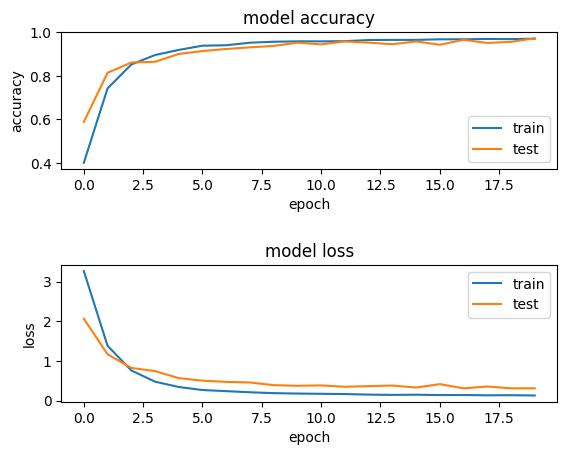

Final Test Accuracy: 0.9800987839698792


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       0.98      1.00      0.99       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       0.91      1.00      0.95       239
          15       1.00      1.00      1.00       235
  

c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python\Pyhton3.10.0\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              301       False
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True
